# Depth_Estimation.ipynb  
By: Shawn Vosburg (260743167)  
Due: November 5th, 2018  
Course: ECSE415, McGill University  

## 2.1 Depth Estimation from Stereo Images

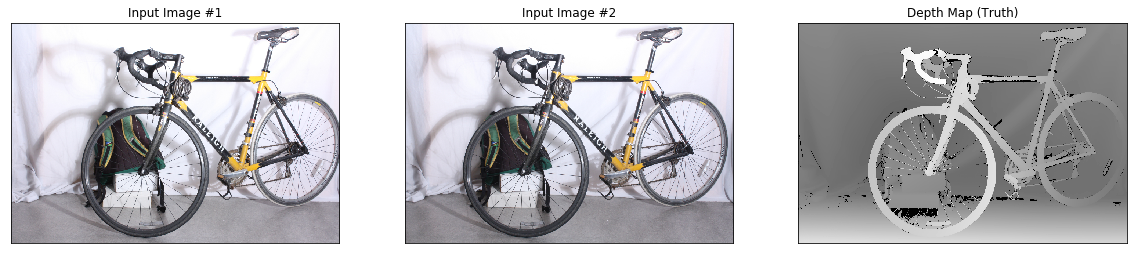

In [6]:
import sys
import re
from struct import *
import cv2
import numpy as np
from matplotlib import pyplot as plt

def read_pfm(file):
    # Adopted from https://stackoverflow.com/questions/37073108/how-to-read-pfm-files-provided-with-middlebury-dataset?rq=1
    with open(file, "rb") as f:
        # Line 1: PF=>RGB (3 channels), Pf=>Greyscale (1 channel)
        type = f.readline().decode('latin-1')
        if "PF" in type:
            channels = 3
        elif "Pf" in type:
            channels = 1
        else:
            sys.exit(1)
        # Line 2: width height
        line = f.readline().decode('latin-1')
        width, height = re.findall('\d+', line)
        width = int(width)
        height = int(height)

        # Line 3: +ve number means big endian, negative means little endian
        line = f.readline().decode('latin-1')
        BigEndian = True
        if "-" in line:
            BigEndian = False
        # Slurp all binary data
        samples = width * height * channels;
        buffer = f.read(samples * 4)
        # Unpack floats with appropriate endianness
        if BigEndian:
            fmt = ">"
        else:
            fmt = "<"
        fmt = fmt + str(samples) + "f"
        img = unpack(fmt, buffer)
        img = np.flipud(np.array(img).reshape(height, width))
    return img


#obtain images and depth map
img0 = cv2.imread('im0.png');
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
img1 = cv2.imread('im1.png');
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
depthTruth = read_pfm('./disp0.pfm')
depthTruth[depthTruth==np.inf] = 0

# resize images for fast processing
img0 = cv2.resize(img0, None, fx=0.3, fy=0.3)
img1 = cv2.resize(img1, None, fx=0.3, fy=0.3)
depthTruth = cv2.resize(depthTruth, None, fx=0.3, fy=0.3)


plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(img0)
plt.title("Input Image #1"), plt.xticks([]), plt.yticks([])
plt.subplot(132)
plt.imshow(img1)
plt.title("Input Image #2"), plt.xticks([]), plt.yticks([])
plt.subplot(133)
plt.imshow(depthTruth,cmap = "gray")
plt.title("Depth Map (Truth)"), plt.xticks([]), plt.yticks([])
plt.show()

## 2.1.1 Estimate depth using the stereo image pair. Show the results of varying the following parameters: blockSize ∈ [5, 10, 15], numDisparities ∈ [16, 32, 48]. You will have a total of 9 depth-maps, each corresponding to one combination of blocksize and numDisparities.

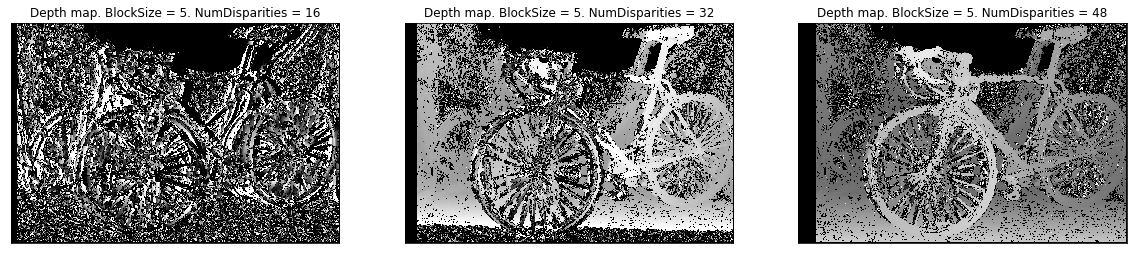

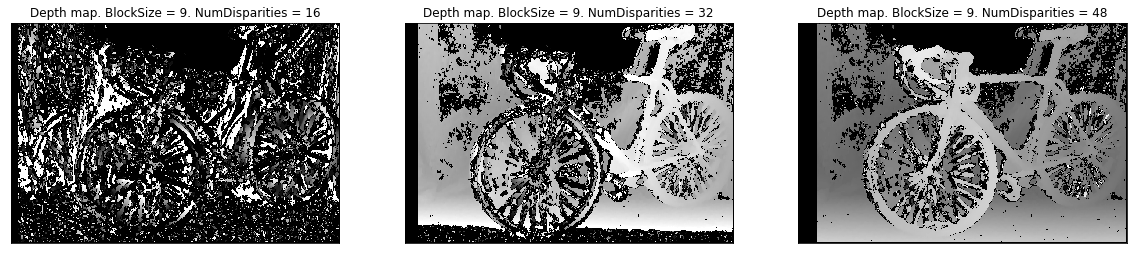

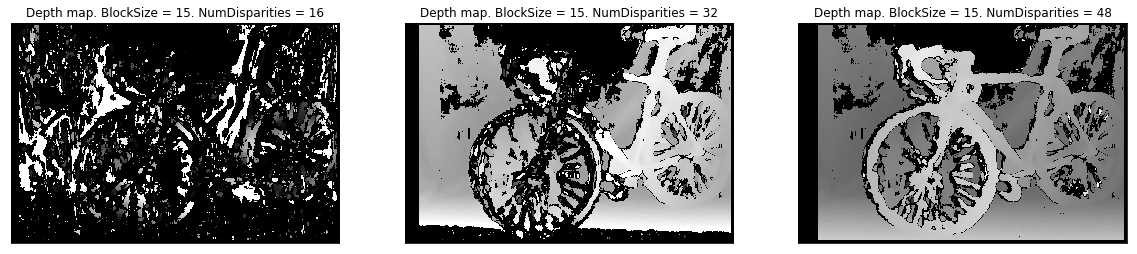

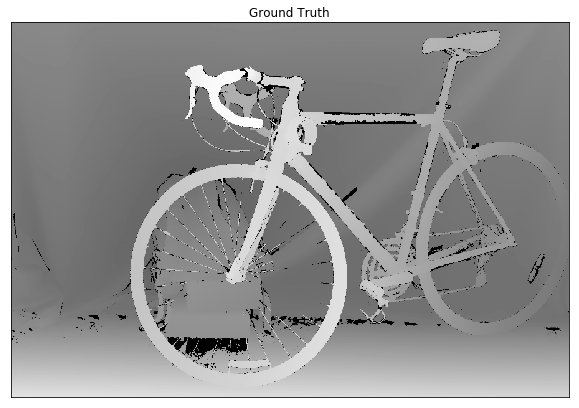

In [67]:
#Get grayscale images so that the original images are not overwritten
img0_gray = cv2.cvtColor(img0, cv2.COLOR_RGB2GRAY)
img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)


#BookKeeping
depthMaps = []
blockSizes = np.array([5,9,15])
numDisparities = np.array([16,32,48])

for bs in range(len(blockSizes)):
    for nd in range(len(numDisparities)):
        # compute disparity map
        stereo = cv2.StereoBM_create(numDisparities=numDisparities[nd], blockSize=blockSizes[bs])
        disparity = stereo.compute(img0_gray, img1_gray)
        #normalize image
        disparity = disparity / max(np.reshape(disparity,-1))
        depthMaps.append(disparity)
        
#normalize groundTruth
depthTruth = depthTruth / max(np.reshape(depthTruth,-1))

#Displaying images
for i in range(3*3):
    if(i%3 == 0):
        plt.figure(figsize=(20,20))
    plt.subplot((int(i/3)+1) * 100 + 30 +(int(i%3)+1))
    plt.imshow(depthMaps[i],cmap = "gray")
    title = "Depth map. BlockSize = " + str(blockSizes[int(i/3)]) + ". NumDisparities = " + str(numDisparities[int(i%3)])
    plt.title(title), plt.xticks([]), plt.yticks([])
    if(i%3 == 3-1):
        plt.show()
        
#Display ground truth
plt.figure(figsize=(10,10))
plt.imshow(depthTruth,cmap = "gray")
plt.title("Ground Truth"), plt.xticks([]), plt.yticks([])
plt.show()


## 2.1.2 For each depth-map, compute the pixel-wise squared difference error with respect to the ground-truth.

In [66]:
#Function to compute the pixel-wise squared difference error 
def SDE(img1):
    total = 0;
    for x in range(img1.shape[1]):
        for y in range(img1.shape[0]):
            total += img1[y][x]**2
    return total


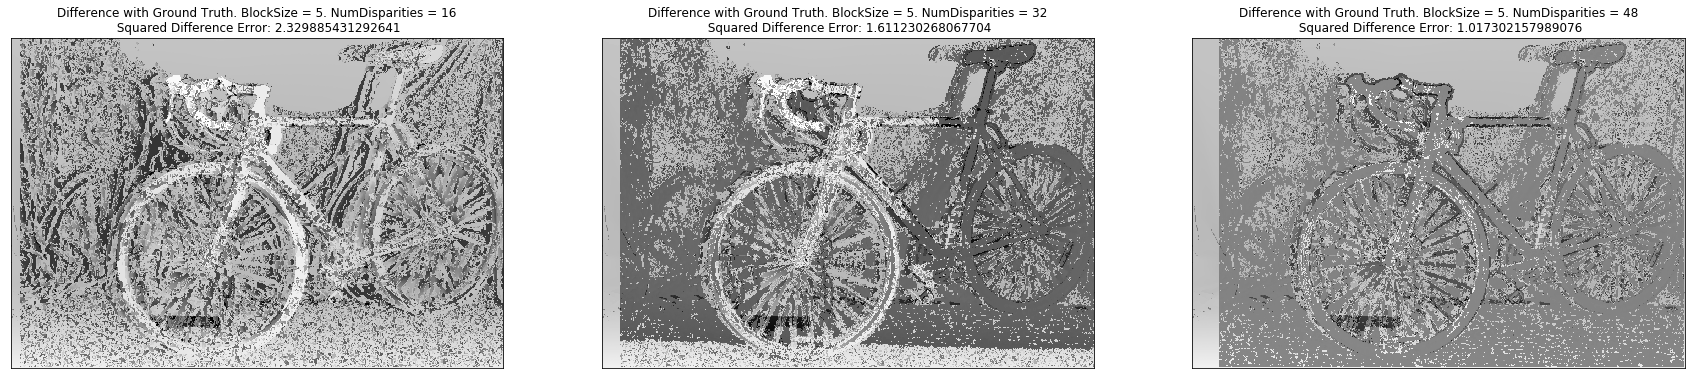

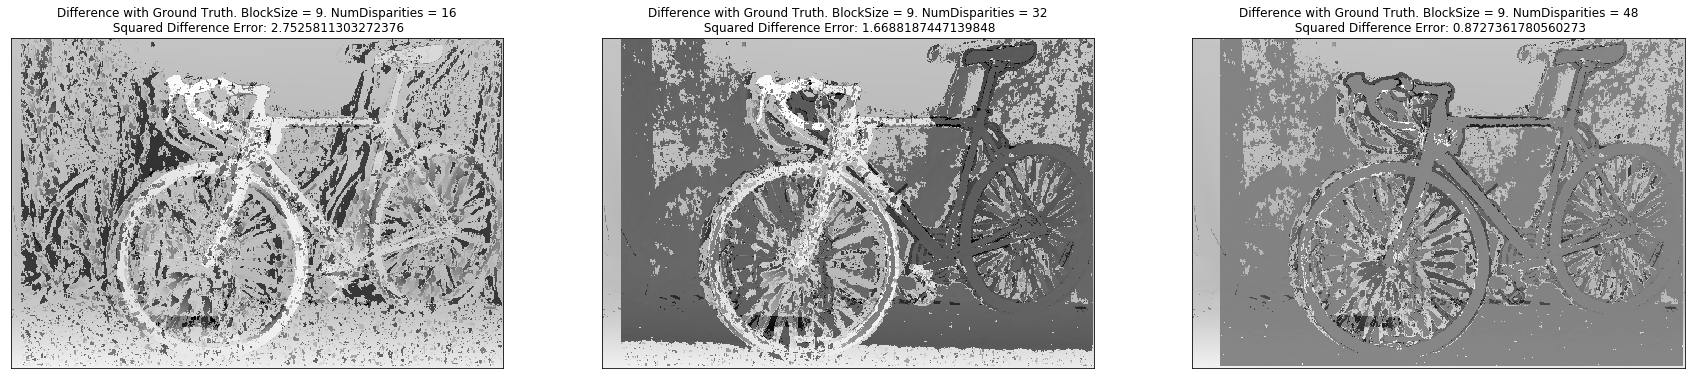

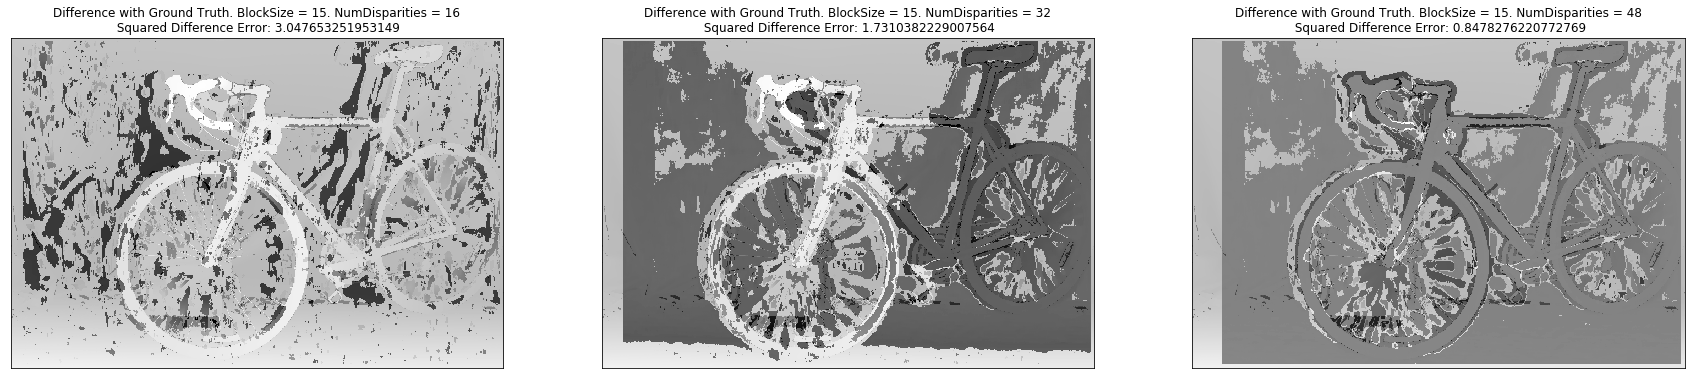

In [68]:
#Create copy as to not overwrite original
groundTruth = depthTruth.copy()
depthMaps2 = depthMaps.copy()


#Compute differences between images
diff = []
for i in range(3*3):
    diff.append(groundTruth/255 - depthMaps2[i]/255)
#Displaying images
for i in range(3*3):
    if(i%3 == 0):
        plt.figure(figsize=(30,30))
    plt.subplot((int(i/3)+1) * 100 + 30 +(int(i%3)+1))
    plt.imshow(diff[i],cmap = "gray")
    title = "Difference with Ground Truth. BlockSize = " + str(blockSizes[int(i/3)]) + ". NumDisparities = " + str(numDisparities[int(i%3)])
    title += "\n Squared Difference Error: " + str(SDE(diff[i]))
    plt.title(title), plt.xticks([]), plt.yticks([])
    if(i%3 == 3-1):
        plt.show()
        

The optimal setting from Sum of Squared Differences:  
BlockSize: 15  
Number of disparities: 48

## 2.1.3 Comment on the error-maps for each combination of parameters. Specifically, mention the effects of varying the parameters on the error in the region of high/low texture, edge, large/small depths.

**ANSWER:**  
There are two parameters that we have control over. There is the block size and the number of disparities. The block size relates to the area around the pixel where a match is search for. The number of disparities is the distance in pixel that the window will be moved away the central pixel to see the movement in pixels. 

The error maps have a lot of noise when the blocksize is low. This can be seen in the background of the top left image, with the lowest blocksize. Having a low blocksize causes a more detailed depth mapth, since where ripples in the background fabric can be seen (see top left depth map from first question). But since the blocksize is low, it is more likely to mistakenly associate the window with another part of the image (especially true with flat and low frequency image). Increasing the block size will lead to a less noisy image as the algorithm has to match more pixels. On the other hand, increasing the block size looses some detail, as more features are being compared. The first row features a low block size. The resulting depth map is noisy in the background for reasons expalined earlier (due to it being a region of low texture) but also cleanly dispicts the ripples in the background curtain, which is a region of edges. The edges on the bike are also very sharp. This is due to having a low block size's ability of conserving sharp details, especially around edges. The spokes can clearly be seen, even near the school bag where they are even hard to see with the naked eye in the original stero images. When increasing the block size, down to the second row for example, the noise starts the dissapear near areas of low texture. The ripples in the background curtain are still present as they are more texturized but are starting to fade away. The edges on the spokes of the front wheel can still be determined as the the block size is still low enough to make out its edges. The last row offers the biggest block size. Almost no noise is present in the image (especially prevalent in the background curtain where low texture is present). The image is obviously smoothed out. The edges of the image are not sharp anymore and vary in diameter. The spokes in the frount wheel near the school bag can no longer be intellegibly recongized. 

When the number of disparities is low, the alogrithm doesn't look far to see how the image has changed. For an image where the shift is pronouced, a low number of disparities can cause the algorithm to have the reach to see the proper depth for objects in the foreground. It is good to identify the depth of the objects in the background however, as these move minimally in stereo images. When the number of disparities is high, the algorithm has a good chance of having enough space to find the movement of the object in the foreground. On the other hand, it has a higher chance of misinterpretating the movment of background objects as the pixels are compared to more distant pixels. For example, if a repeating pattern is present in the background, the algorithm set with a high number of disparities may mismatch the pattern in the background, causing the algorithm to believe it is in the foreground as it has moved a lot of pixels. In our case, having a low number of disparities causes the the images to not identify the depth of the wheel in the foreground, as the region of search is not large enough to detect what the true depth is, so the front wheel is black. By increasing the number of disparities the front wheel becomes detectable, as seen by the last coloumn of the images. In the middle coloumn, you can see exactly when the number of disparities becomes large enough for the depth of images. In the middle of the bike, the depth suddenly becomes bright white, signifying a large change in distance. What is happening here is that the number of disparities was not large enough to detect the stereo movement in the foreground but was large enough to detect images in the background.  

